In [77]:
import pandas as pd
import numpy as np
import os
import ast
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import optuna
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
os.getcwd()

'/Users/tasukukurasawa/projectdir/data-science-portfolio-taskmemo/study/taxi_trajectory'

In [4]:
df_train = pd.read_csv("/Users/tasukukurasawa/projectdir/data-science-portfolio-taskmemo/data/train.csv")
df_test = pd.read_csv("/Users/tasukukurasawa/projectdir/data-science-portfolio-taskmemo/data/test.csv")
df_loc = pd.read_csv("/Users/tasukukurasawa/projectdir/data-science-portfolio-taskmemo/data/metaData_taxistandsID_name_GPSlocation.csv")

In [5]:
df_train.head()

TRIP_ID CALL_TYPE  ORIGIN_CALL  ORIGIN_STAND   TAXI_ID  \
0  1372636858620000589         C          NaN           NaN  20000589   
1  1372637303620000596         B          NaN           7.0  20000596   
2  1372636951620000320         C          NaN           NaN  20000320   
3  1372636854620000520         C          NaN           NaN  20000520   
4  1372637091620000337         C          NaN           NaN  20000337   

    TIMESTAMP DAY_TYPE  MISSING_DATA  \
0  1372636858        A         False   
1  1372637303        A         False   
2  1372636951        A         False   
3  1372636854        A         False   
4  1372637091        A         False   

                                            POLYLINE  
0  [[-8.618643,41.141412],[-8.618499,41.141376],[...  
1  [[-8.639847,41.159826],[-8.640351,41.159871],[...  
2  [[-8.612964,41.140359],[-8.613378,41.14035],[-...  
3  [[-8.574678,41.151951],[-8.574705,41.151942],[...  
4  [[-8.645994,41.18049],[-8.645949,41.180517],[-...

In [6]:
df_loc.head()

ID  Descricao       Latitude  Longitude
0   1       Agra  41.1771457135  -8.609670
1   2    Alameda    41.15618964  -8.591064
2   3     Aldoar  41.1705249231  -8.665876
3   4  Alfândega  41.1437639911  -8.621803
4   5      Amial  41.1835097223  -8.612726

In [7]:
print("train: ",df_train.shape)
print("test: ",df_test.shape)
print("location: ",df_loc.shape)

train:  (1710670, 9)
test:  (320, 9)
location:  (63, 4)


## EDA

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1710670 entries, 0 to 1710669
Data columns (total 9 columns):
 #   Column        Dtype  
---  ------        -----  
 0   TRIP_ID       int64  
 1   CALL_TYPE     object 
 2   ORIGIN_CALL   float64
 3   ORIGIN_STAND  float64
 4   TAXI_ID       int64  
 5   TIMESTAMP     int64  
 6   DAY_TYPE      object 
 7   MISSING_DATA  bool   
 8   POLYLINE      object 
dtypes: bool(1), float64(2), int64(3), object(3)
memory usage: 106.0+ MB


In [9]:
df_train.isnull().sum()

TRIP_ID               0
CALL_TYPE             0
ORIGIN_CALL     1345900
ORIGIN_STAND     904091
TAXI_ID               0
TIMESTAMP             0
DAY_TYPE              0
MISSING_DATA          0
POLYLINE              0
dtype: int64

ORIGIN_CALL, ORIGIN_STAND columns are many missing values, then handle later.

## feature engineering

In [10]:
df_sample = df_train.sample(frac=0.03, random_state=42).reset_index(drop=True)
df_sample.shape

(51320, 9)

In [11]:
df_sample.head()

TRIP_ID CALL_TYPE  ORIGIN_CALL  ORIGIN_STAND   TAXI_ID  \
0  1399190091620000213         B          NaN          10.0  20000213   
1  1398928351620000092         C          NaN           NaN  20000092   
2  1383056851620000263         B          NaN           9.0  20000263   
3  1399758505620000503         B          NaN          13.0  20000503   
4  1390920415620000174         B          NaN          10.0  20000174   

    TIMESTAMP DAY_TYPE  MISSING_DATA  \
0  1399190091        A         False   
1  1398928351        A         False   
2  1383056851        A         False   
3  1399758505        A         False   
4  1390920415        A         False   

                                            POLYLINE  
0  [[-8.607096,41.150286],[-8.607123,41.150214],[...  
1  [[-8.638533,41.159133],[-8.63856,41.15907],[-8...  
2  [[-8.60652,41.144562],[-8.606934,41.144724],[-...  
3  [[-8.628246,41.157333],[-8.627733,41.157657],[...  
4  [[-8.607123,41.150331],[-8.607114,41.150295],[...

In [12]:
# gerenete features from POLYLINE
df_sample["polyline_list"] = df_sample["POLYLINE"].apply(lambda x: ast.literal_eval(x))
df_sample["n_points"] = df_sample["polyline_list"].apply(lambda x: len(x))
df_sample["start_lon"] = df_sample["polyline_list"].apply(lambda x: x[0][0] if len(x) > 0 else np.nan)
df_sample["start_lat"] = df_sample["polyline_list"].apply(lambda x: x[0][1] if len(x) > 0 else np.nan)
df_sample["end_lon"] = df_sample["polyline_list"].apply(lambda x: x[-1][0] if len(x) > 0 else np.nan)
df_sample["end_lat"] = df_sample["polyline_list"].apply(lambda x: x[-1][1] if len(x) > 0 else np.nan)

In [13]:
def haversine(lat1, lon1, lat2, lon2):
    """ Calculate the great circle distance between two points"""
    R = 6371.0 # the earth radius in kilometers
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return 2 * R * np.arcsin(np.sqrt(a))

def calculate_distance(polyline):
    if len(polyline) < 2:
        return 0.0
    dist = 0.0
    for i in range(1, len(polyline)):
        lon1, lat1 = polyline[i-1]
        lon2, lat2 = polyline[i]
        dist += haversine(lat1, lon1, lat2, lon2)
    return dist

In [14]:
#generate features: partial distance, run time, avg speed

df_sample["partial_polyline"] = df_sample["polyline_list"].apply(lambda x: x[:30] if len(x) > 30 else x)
df_sample["partial_distance"] = df_sample["partial_polyline"].apply(calculate_distance)
df_sample["run_time_sec"] = df_sample["n_points"] * 15
df_sample["run_time_hr"] = df_sample["run_time_sec"] / 3600
df_sample["avg_speed_kmh"] = df_sample["partial_distance"] / df_sample["run_time_hr"].replace(0, np.nan)

In [15]:
df_sample.head()

TRIP_ID CALL_TYPE  ORIGIN_CALL  ORIGIN_STAND   TAXI_ID  \
0  1399190091620000213         B          NaN          10.0  20000213   
1  1398928351620000092         C          NaN           NaN  20000092   
2  1383056851620000263         B          NaN           9.0  20000263   
3  1399758505620000503         B          NaN          13.0  20000503   
4  1390920415620000174         B          NaN          10.0  20000174   

    TIMESTAMP DAY_TYPE  MISSING_DATA  \
0  1399190091        A         False   
1  1398928351        A         False   
2  1383056851        A         False   
3  1399758505        A         False   
4  1390920415        A         False   

                                            POLYLINE  \
0  [[-8.607096,41.150286],[-8.607123,41.150214],[...   
1  [[-8.638533,41.159133],[-8.63856,41.15907],[-8...   
2  [[-8.60652,41.144562],[-8.606934,41.144724],[-...   
3  [[-8.628246,41.157333],[-8.627733,41.157657],[...   
4  [[-8.607123,41.150331],[-8.607114,41.150295],[...   

                                       polyline_list  n_points  start_lon  \
0  [[-8.607096, 41.150286], [-8.607123, 41.150214...        71  -8.607096   
1  [[-8.638533, 41.159133], [-8.63856, 41.15907],...        70  -8.638533   
2  [[-8.60652, 41.144562], [-8.606934, 41.144724]...        38  -8.606520   
3  [[-8.628246, 41.157333], [-8.627733, 41.157657...        31  -8.628246   
4  [[-8.607123, 41.150331], [-8.607114, 41.150295...       231  -8.607123   

   start_lat   end_lon    end_lat  \
0  41.150286 -8.679096  41.158161   
1  41.159133 -8.585847  41.148756   
2  41.144562 -8.594757  41.158836   
3  41.157333 -8.605197  41.146668   
4  41.150331 -8.610255  41.153445   

                                    partial_polyline  partial_distance  \
0  [[-8.607096, 41.150286], [-8.607123, 41.150214...          2.643182   
1  [[-8.638533, 41.159133], [-8.63856, 41.15907],...          1.116930   
2  [[-8.60652, 41.144562], [-8.606934, 41.144724]...          2.290315   
3  [[-8.628246, 41.157333], [-8.627733, 41.157657...          3.021838   
4  [[-8.607123, 41.150331], [-8.607114, 41.150295...          3.971895   

   run_time_sec  run_time_hr  avg_speed_kmh  
0          1065     0.295833       8.934698  
1          1050     0.291667       3.829474  
2           570     0.158333      14.465149  
3           465     0.129167      23.394877  
4          3465     0.962500       4.126644

In [16]:
df_sample.isnull().sum()

TRIP_ID                 0
CALL_TYPE               0
ORIGIN_CALL         40331
ORIGIN_STAND        27308
TAXI_ID                 0
TIMESTAMP               0
DAY_TYPE                0
MISSING_DATA            0
POLYLINE                0
polyline_list           0
n_points                0
start_lon             176
start_lat             176
end_lon               176
end_lat               176
partial_polyline        0
partial_distance        0
run_time_sec            0
run_time_hr             0
avg_speed_kmh         176
dtype: int64

緯度と経度のカラムが欠損値になっているレコードは削除する。

In [17]:
df_sample.dropna(subset=["start_lon"], inplace=True)

In [18]:
df_sample.isnull().sum()

TRIP_ID                 0
CALL_TYPE               0
ORIGIN_CALL         40168
ORIGIN_STAND        27187
TAXI_ID                 0
TIMESTAMP               0
DAY_TYPE                0
MISSING_DATA            0
POLYLINE                0
polyline_list           0
n_points                0
start_lon               0
start_lat               0
end_lon                 0
end_lat                 0
partial_polyline        0
partial_distance        0
run_time_sec            0
run_time_hr             0
avg_speed_kmh           0
dtype: int64

## test data distirbution

In [19]:
df_test["polyline_list"] = df_test["POLYLINE"].apply(lambda x: ast.literal_eval(x))
df_test["n_points"] = df_test["polyline_list"].apply(lambda x: len(x))
df_test.head()

TRIP_ID CALL_TYPE  ORIGIN_CALL  ORIGIN_STAND   TAXI_ID   TIMESTAMP DAY_TYPE  \
0      T1         B          NaN          15.0  20000542  1408039037        A   
1      T2         B          NaN          57.0  20000108  1408038611        A   
2      T3         B          NaN          15.0  20000370  1408038568        A   
3      T4         B          NaN          53.0  20000492  1408039090        A   
4      T5         B          NaN          18.0  20000621  1408039177        A   

   MISSING_DATA                                           POLYLINE  \
0         False  [[-8.585676,41.148522],[-8.585712,41.148639],[...   
1         False  [[-8.610876,41.14557],[-8.610858,41.145579],[-...   
2         False  [[-8.585739,41.148558],[-8.58573,41.148828],[-...   
3         False  [[-8.613963,41.141169],[-8.614125,41.141124],[...   
4         False      [[-8.619903,41.148036],[-8.619894,41.148036]]   

                                       polyline_list  n_points  
0  [[-8.585676, 41.148522], [-8.585712, 41.148639...        11  
1  [[-8.610876, 41.14557], [-8.610858, 41.145579]...        40  
2  [[-8.585739, 41.148558], [-8.58573, 41.148828]...        40  
3  [[-8.613963, 41.141169], [-8.614125, 41.141124...         8  
4   [[-8.619903, 41.148036], [-8.619894, 41.148036]]         2

<Axes: >

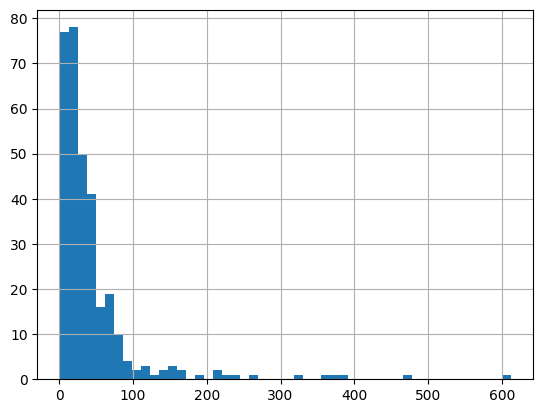

In [20]:
df_test.n_points.hist(bins=50)

In [21]:
df_test["n_points"].describe()

count    320.000000
mean      45.118750
std       66.739927
min        1.000000
25%       14.000000
50%       26.500000
75%       48.000000
max      612.000000
Name: n_points, dtype: float64

テストデータのn_pointsの分布を確認したところ、30ステップまでが多いことがわかったことから、学習データにおいても30ステップまでの距離、時間、平均速度を特徴量として追加することとする。

## Training base model
欠損値の保管は一旦無視。特徴量として除外するのは、ID関連、ORIGIN_CALL, ORIGIN_STAND。

In [22]:
features = [
    "start_lat",
    "start_lon",
    "partial_distance",
    "run_time_hr",
    "avg_speed_kmh",
    "n_points",
]
x_reduced = df_sample[features]
y_lat = df_sample["end_lat"]
y_lon = df_sample["end_lon"]

In [23]:
x_reduced.info()

<class 'pandas.core.frame.DataFrame'>
Index: 51144 entries, 0 to 51319
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   start_lat         51144 non-null  float64
 1   start_lon         51144 non-null  float64
 2   partial_distance  51144 non-null  float64
 3   run_time_hr       51144 non-null  float64
 4   avg_speed_kmh     51144 non-null  float64
 5   n_points          51144 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 2.7 MB


In [24]:
def training_model(x,y, model_type="linear", use_cv=True, n_splits=5):
    """ train regression model(linear regression or random forest"""
    steps=[]
    steps.append(('scaler', StandardScaler()))
    
    # model selection
    if model_type == "linear":
        steps.append(('regressor', LinearRegression()))
    elif model_type == "random_forest":
        steps.append(('regressor', RandomForestRegressor()))
    
    pipe = Pipeline(steps)

    # cross-validation
    if use_cv:
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
        cv_scores = cross_val_score(pipe, x, y, cv=kf, scoring='neg_mean_squared_error')
        print(f"CV Mean Squared Error: {-np.mean(cv_scores)}")
        pipe.fit(x, y)
    else:
        pipe.fit(x, y)
        print("Model trained without cross-validation.")
    
    return pipe

def evaluate_model(x, y_lat, y_lon, test_size=0.2, model_type="linear", use_cv=False):
    """ evaluate latitude / longitude prediction model using Haversine distance """
    x_train, x_test, y_train_lat, y_test_lat = train_test_split(x, y_lat, test_size=test_size, random_state=42)
    _, _, y_train_lon, y_test_lon = train_test_split(x, y_lon, test_size=test_size, random_state=42)
    
    # training model
    model_lat = training_model(x_train, y_train_lat, model_type=model_type, use_cv=use_cv)
    model_lon = training_model(x_train, y_train_lon, model_type=model_type, use_cv=use_cv)
    
    # prediction
    pred_lat = model_lat.predict(x_test)
    pred_lon = model_lon.predict(x_test)

    # calculate Haversine distance error
    error_km = haversine(y_test_lat, y_test_lon, pred_lat, pred_lon)
    
    print(f"error kilo of mean: {error_km.mean():.3f} km")
    print(f"error kilo of median: {np.median(error_km):.3f} km")
    
    return model_lat, model_lon, error_km


In [25]:
# evaluate model
evaluate_model(x_reduced, y_lat, y_lon, test_size=0.2, model_type="random_forest")

Model trained without cross-validation.
Model trained without cross-validation.
error kilo of mean: 2.706 km
error kilo of median: 1.873 km


(Pipeline(steps=[('scaler', StandardScaler()),
                 ('regressor', RandomForestRegressor())]),
 Pipeline(steps=[('scaler', StandardScaler()),
                 ('regressor', RandomForestRegressor())]),
 17194    1.781976
 48947    0.313870
 48741    0.975662
 14134    7.459273
 12432    2.352060
            ...   
 50807    2.584789
 21093    0.493985
 37469    7.258618
 32902    1.952480
 2307     3.460973
 Length: 10229, dtype: float64)

In [26]:
evaluate_model(x_reduced, y_lat, y_lon, test_size=0.2, model_type="linear")

Model trained without cross-validation.
Model trained without cross-validation.
error kilo of mean: 3.005 km
error kilo of median: 2.295 km


(Pipeline(steps=[('scaler', StandardScaler()),
                 ('regressor', LinearRegression())]),
 Pipeline(steps=[('scaler', StandardScaler()),
                 ('regressor', LinearRegression())]),
 17194     1.396649
 48947     0.967738
 48741     1.828312
 14134     8.158131
 12432     2.170682
            ...    
 50807     3.631078
 21093     0.153832
 37469    10.244421
 32902     0.695041
 2307      4.784169
 Length: 10229, dtype: float64)

In [27]:
evaluate_model(x_reduced, y_lat, y_lon, test_size=0.2, model_type="random_forest", use_cv=True)

CV Mean Squared Error: 0.0014668001432835058
CV Mean Squared Error: 0.0011351908976790755
error kilo of mean: 2.715 km
error kilo of median: 1.885 km


(Pipeline(steps=[('scaler', StandardScaler()),
                 ('regressor', RandomForestRegressor())]),
 Pipeline(steps=[('scaler', StandardScaler()),
                 ('regressor', RandomForestRegressor())]),
 17194    1.466064
 48947    0.461006
 48741    0.931446
 14134    7.436089
 12432    2.387677
            ...   
 50807    2.590452
 21093    0.501805
 37469    7.120702
 32902    2.012150
 2307     3.463088
 Length: 10229, dtype: float64)

In [28]:
evaluate_model(x_reduced, y_lat, y_lon, test_size=0.2, model_type="linear", use_cv=True)

CV Mean Squared Error: 0.0013704452551151815
CV Mean Squared Error: 0.001262299662106506
error kilo of mean: 3.005 km
error kilo of median: 2.295 km


(Pipeline(steps=[('scaler', StandardScaler()),
                 ('regressor', LinearRegression())]),
 Pipeline(steps=[('scaler', StandardScaler()),
                 ('regressor', LinearRegression())]),
 17194     1.396649
 48947     0.967738
 48741     1.828312
 14134     8.158131
 12432     2.170682
            ...    
 50807     3.631078
 21093     0.153832
 37469    10.244421
 32902     0.695041
 2307      4.784169
 Length: 10229, dtype: float64)

## test data validation with base model

In [29]:
def preprocess_taxi(df, partial_cut=30):
    """ Preprocess taxi trajectory data to generate features from POLYLINE"""
    
    # POLYLINE to list
    df["polyline_list"] = df["POLYLINE"].apply(ast.literal_eval)
    df["n_points"] = df["polyline_list"].apply(len)
    
    # start points
    df["start_lon"] = df["polyline_list"].apply(lambda x: x[0][0] if len(x) > 0 else np.nan)
    df["start_lat"] = df["polyline_list"].apply(lambda x: x[0][1] if len(x) > 0 else np.nan)
    
    # end points (only if not exists)
    if "end_lon" not in df.columns:
        df["end_lon"] = df["polyline_list"].apply(lambda x: x[-1][0] if len(x) > 0 else np.nan)
        df["end_lat"] = df["polyline_list"].apply(lambda x: x[-1][1] if len(x) > 0 else np.nan)
    
    # partial polyline
    df["partial_polyline"] = df["polyline_list"].apply(
        lambda x: x[:partial_cut] if len(x) > partial_cut else x
    )
    
    # calculate distance, run time, avg speed
    df["partial_distance"] = df["partial_polyline"].apply(calculate_distance)
    df["run_time_sec"] = df["n_points"] * 15
    df["run_time_hr"] = df["run_time_sec"] / 3600
    df["avg_speed_kmh"] = df["partial_distance"] / df["run_time_hr"].replace(0, np.nan)
    
    # drop rows with missing start coordinates
    df = df.dropna(subset=["start_lon", "start_lat"])
    
    return df

In [30]:
df_test = preprocess_taxi(df_test, partial_cut=30)
x_test_reduced = df_test[features]


In [31]:
model_lat, model_lon, error_km = evaluate_model(
    x_reduced, y_lat, y_lon, 
    test_size=0.2, model_type="random_forest"
)

# predict on test data
pred_lat = model_lat.predict(x_test_reduced)
pred_lon = model_lon.predict(x_test_reduced)

Model trained without cross-validation.
Model trained without cross-validation.
error kilo of mean: 2.710 km
error kilo of median: 1.875 km


In [32]:
df_submit = pd.DataFrame({
    "TRIP_ID": df_test["TRIP_ID"],
    "LATITUDE": pred_lat,
    "LONGITUDE": pred_lon
})

df_submit.to_csv("/Users/tasukukurasawa/projectdir/data-science-portfolio-taskmemo/data/taxi_trajectory_submission.csv", index=False)

test dataによるsubmissionの結果は以下の通り。
- model : RandomForestRegressor(n_estimators=100, random_state=42)
- public score: 3.84330 km
- private score: 4.03655 km

## feature importance

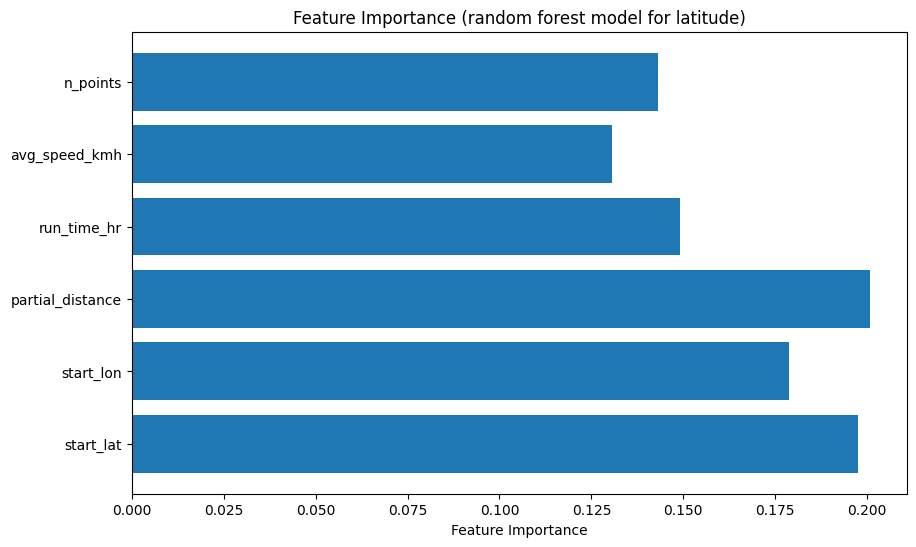

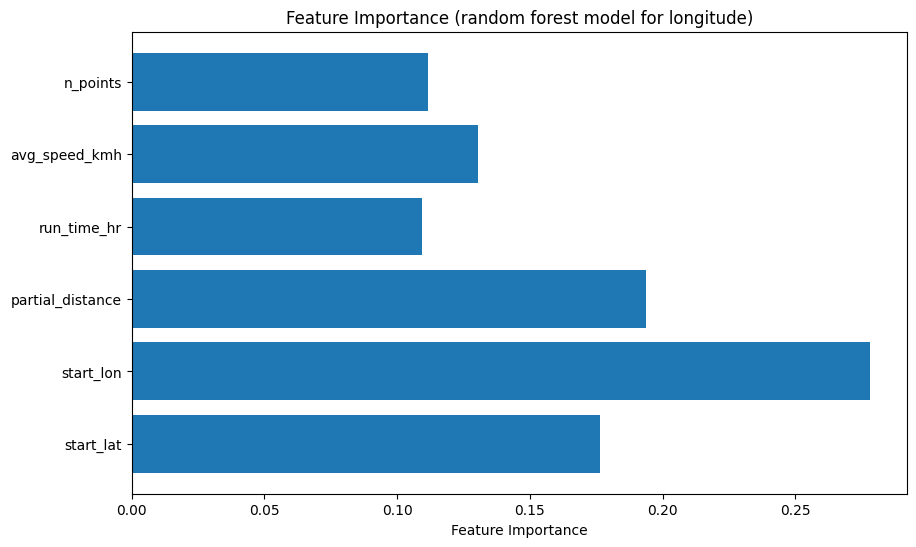

In [35]:
# model feature importance visualization
model_lat_rf = model_lat.named_steps['regressor']
model_lon_rf = model_lon.named_steps['regressor']

# latitude feature importance
plt.figure(figsize=(10, 6))
plt.barh(range(len(model_lat_rf.feature_importances_)), model_lat_rf.feature_importances_)
plt.yticks(range(len(model_lat_rf.feature_importances_)), x_reduced.columns)
plt.xlabel("Feature Importance")
plt.title("Feature Importance (random forest model for latitude)")
plt.show()

# longitude feature importance
plt.figure(figsize=(10, 6))
plt.barh(range(len(model_lon_rf.feature_importances_)), model_lon_rf.feature_importances_)
plt.yticks(range(len(model_lon_rf.feature_importances_)), x_reduced.columns)
plt.xlabel("Feature Importance")
plt.title("Feature Importance (random forest model for longitude)")
plt.show()

start_lon, start_lat, partial_distanceが重要な特徴量であることがわかった。

## feature engineering ver2
- CALL_TYPE, DAYTYPEのエンコーディング
- TIMESTAMPから時間に関する特徴量の生成

In [36]:
df_sample.head()

TRIP_ID CALL_TYPE  ORIGIN_CALL  ORIGIN_STAND   TAXI_ID  \
0  1399190091620000213         B          NaN          10.0  20000213   
1  1398928351620000092         C          NaN           NaN  20000092   
2  1383056851620000263         B          NaN           9.0  20000263   
3  1399758505620000503         B          NaN          13.0  20000503   
4  1390920415620000174         B          NaN          10.0  20000174   

    TIMESTAMP DAY_TYPE  MISSING_DATA  \
0  1399190091        A         False   
1  1398928351        A         False   
2  1383056851        A         False   
3  1399758505        A         False   
4  1390920415        A         False   

                                            POLYLINE  \
0  [[-8.607096,41.150286],[-8.607123,41.150214],[...   
1  [[-8.638533,41.159133],[-8.63856,41.15907],[-8...   
2  [[-8.60652,41.144562],[-8.606934,41.144724],[-...   
3  [[-8.628246,41.157333],[-8.627733,41.157657],[...   
4  [[-8.607123,41.150331],[-8.607114,41.150295],[...   

                                       polyline_list  n_points  start_lon  \
0  [[-8.607096, 41.150286], [-8.607123, 41.150214...        71  -8.607096   
1  [[-8.638533, 41.159133], [-8.63856, 41.15907],...        70  -8.638533   
2  [[-8.60652, 41.144562], [-8.606934, 41.144724]...        38  -8.606520   
3  [[-8.628246, 41.157333], [-8.627733, 41.157657...        31  -8.628246   
4  [[-8.607123, 41.150331], [-8.607114, 41.150295...       231  -8.607123   

   start_lat   end_lon    end_lat  \
0  41.150286 -8.679096  41.158161   
1  41.159133 -8.585847  41.148756   
2  41.144562 -8.594757  41.158836   
3  41.157333 -8.605197  41.146668   
4  41.150331 -8.610255  41.153445   

                                    partial_polyline  partial_distance  \
0  [[-8.607096, 41.150286], [-8.607123, 41.150214...          2.643182   
1  [[-8.638533, 41.159133], [-8.63856, 41.15907],...          1.116930   
2  [[-8.60652, 41.144562], [-8.606934, 41.144724]...          2.290315   
3  [[-8.628246, 41.157333], [-8.627733, 41.157657...          3.021838   
4  [[-8.607123, 41.150331], [-8.607114, 41.150295...          3.971895   

   run_time_sec  run_time_hr  avg_speed_kmh  
0          1065     0.295833       8.934698  
1          1050     0.291667       3.829474  
2           570     0.158333      14.465149  
3           465     0.129167      23.394877  
4          3465     0.962500       4.126644

In [37]:
df_sample["CALL_TYPE"].value_counts()

CALL_TYPE
B    24284
C    15884
A    10976
Name: count, dtype: int64

In [ ]:
df_sample["DAY_TYPE"].value_counts()

DAY_TYPE
A    51144
Name: count, dtype: int64

In [40]:
df_sample["MISSING_DATA"].value_counts()

MISSING_DATA
False    51143
True         1
Name: count, dtype: int64

In [41]:
# generate time-related features from TIMESTAMP
df_sample["datetime"] = pd.to_datetime(df_sample["TIMESTAMP"], unit='s')
df_sample["hour"] = df_sample["datetime"].dt.hour
df_sample["weekday"] = df_sample["datetime"].dt.weekday
df_sample.head()

TRIP_ID CALL_TYPE  ORIGIN_CALL  ORIGIN_STAND   TAXI_ID  \
0  1399190091620000213         B          NaN          10.0  20000213   
1  1398928351620000092         C          NaN           NaN  20000092   
2  1383056851620000263         B          NaN           9.0  20000263   
3  1399758505620000503         B          NaN          13.0  20000503   
4  1390920415620000174         B          NaN          10.0  20000174   

    TIMESTAMP DAY_TYPE  MISSING_DATA  \
0  1399190091        A         False   
1  1398928351        A         False   
2  1383056851        A         False   
3  1399758505        A         False   
4  1390920415        A         False   

                                            POLYLINE  \
0  [[-8.607096,41.150286],[-8.607123,41.150214],[...   
1  [[-8.638533,41.159133],[-8.63856,41.15907],[-8...   
2  [[-8.60652,41.144562],[-8.606934,41.144724],[-...   
3  [[-8.628246,41.157333],[-8.627733,41.157657],[...   
4  [[-8.607123,41.150331],[-8.607114,41.150295],[...   

                                       polyline_list  ...   end_lon  \
0  [[-8.607096, 41.150286], [-8.607123, 41.150214...  ... -8.679096   
1  [[-8.638533, 41.159133], [-8.63856, 41.15907],...  ... -8.585847   
2  [[-8.60652, 41.144562], [-8.606934, 41.144724]...  ... -8.594757   
3  [[-8.628246, 41.157333], [-8.627733, 41.157657...  ... -8.605197   
4  [[-8.607123, 41.150331], [-8.607114, 41.150295...  ... -8.610255   

     end_lat                                   partial_polyline  \
0  41.158161  [[-8.607096, 41.150286], [-8.607123, 41.150214...   
1  41.148756  [[-8.638533, 41.159133], [-8.63856, 41.15907],...   
2  41.158836  [[-8.60652, 41.144562], [-8.606934, 41.144724]...   
3  41.146668  [[-8.628246, 41.157333], [-8.627733, 41.157657...   
4  41.153445  [[-8.607123, 41.150331], [-8.607114, 41.150295...   

   partial_distance  run_time_sec run_time_hr  avg_speed_kmh  \
0          2.643182          1065    0.295833       8.934698   
1          1.116930          1050    0.291667       3.829474   
2          2.290315           570    0.158333      14.465149   
3          3.021838           465    0.129167      23.394877   
4          3.971895          3465    0.962500       4.126644   

             datetime  hour  weekday  
0 2014-05-04 07:54:51     7        6  
1 2014-05-01 07:12:31     7        3  
2 2013-10-29 14:27:31    14        1  
3 2014-05-10 21:48:25    21        5  
4 2014-01-28 14:46:55    14        1  

[5 rows x 23 columns]

In [44]:
agg_df = (
    df_sample.groupby(["weekday", "hour"])["partial_distance"]
    .mean().reset_index()
    .rename(columns={"partial_distance": "avg_partial_distance_by_time"})
)
agg_df.head()

weekday  hour  avg_partial_distance_by_time
0        0     0                      3.566948
1        0     1                      3.195287
2        0     2                      4.070658
3        0     3                      4.636766
4        0     4                      4.746107

In [45]:
df_sample = df_sample.merge(agg_df, on=["weekday", "hour"], how="left")
df_sample.head()

TRIP_ID CALL_TYPE  ORIGIN_CALL  ORIGIN_STAND   TAXI_ID  \
0  1399190091620000213         B          NaN          10.0  20000213   
1  1398928351620000092         C          NaN           NaN  20000092   
2  1383056851620000263         B          NaN           9.0  20000263   
3  1399758505620000503         B          NaN          13.0  20000503   
4  1390920415620000174         B          NaN          10.0  20000174   

    TIMESTAMP DAY_TYPE  MISSING_DATA  \
0  1399190091        A         False   
1  1398928351        A         False   
2  1383056851        A         False   
3  1399758505        A         False   
4  1390920415        A         False   

                                            POLYLINE  \
0  [[-8.607096,41.150286],[-8.607123,41.150214],[...   
1  [[-8.638533,41.159133],[-8.63856,41.15907],[-8...   
2  [[-8.60652,41.144562],[-8.606934,41.144724],[-...   
3  [[-8.628246,41.157333],[-8.627733,41.157657],[...   
4  [[-8.607123,41.150331],[-8.607114,41.150295],[...   

                                       polyline_list  ...    end_lat  \
0  [[-8.607096, 41.150286], [-8.607123, 41.150214...  ...  41.158161   
1  [[-8.638533, 41.159133], [-8.63856, 41.15907],...  ...  41.148756   
2  [[-8.60652, 41.144562], [-8.606934, 41.144724]...  ...  41.158836   
3  [[-8.628246, 41.157333], [-8.627733, 41.157657...  ...  41.146668   
4  [[-8.607123, 41.150331], [-8.607114, 41.150295...  ...  41.153445   

                                    partial_polyline  partial_distance  \
0  [[-8.607096, 41.150286], [-8.607123, 41.150214...          2.643182   
1  [[-8.638533, 41.159133], [-8.63856, 41.15907],...          1.116930   
2  [[-8.60652, 41.144562], [-8.606934, 41.144724]...          2.290315   
3  [[-8.628246, 41.157333], [-8.627733, 41.157657...          3.021838   
4  [[-8.607123, 41.150331], [-8.607114, 41.150295...          3.971895   

   run_time_sec  run_time_hr avg_speed_kmh            datetime  hour  weekday  \
0          1065     0.295833      8.934698 2014-05-04 07:54:51     7        6   
1          1050     0.291667      3.829474 2014-05-01 07:12:31     7        3   
2           570     0.158333     14.465149 2013-10-29 14:27:31    14        1   
3           465     0.129167     23.394877 2014-05-10 21:48:25    21        5   
4          3465     0.962500      4.126644 2014-01-28 14:46:55    14        1   

   avg_partial_distance_by_time  
0                      3.624797  
1                      3.011890  
2                      2.583428  
3                      3.003244  
4                      2.583428  

[5 rows x 24 columns]

特徴量エンジニアリングに関する考察:
- DAY_TYPEのvalue_countsを見ると、Aしか存在していないことがわかったため、特徴量としては使用しない。
- CALL_TYPEのvalue_countsを見ると、Bが多いため、one-hot encodingでエンコーディングする。
- MISSING_DATAのvalue_countsを見ると、Trueが一つだけ存在しているが、精度には関係しないことを踏まえて、無視する。
    - 線形モデルはdrop_first=Trueでエンコーディング
    - 決定木モデルはそのまま使用
- TIMESTAMPから時間に関する特徴量を生成する。
    - 時間帯(hour)と曜日(weekday),時間帯×曜日の組み合わせでpartial_distanceの平均値を集計し、特徴量として追加する。

## train model with feature engineering ver2
Add features:
- CALL_TYPE (one-hot encoding)
- hour (from TIMESTAMP)
- weekday (from TIMESTAMP)
- avg_partial_distance_by_time (aggregated feature by hour and weekday)

In [52]:
features_ver2 = [
    "start_lat",
    "start_lon",
    "partial_distance",
    "avg_partial_distance_by_time", # 時間帯・曜日の平均距離
    "hour",
    "weekday",
    "run_time_hr",
    "avg_speed_kmh",
    "n_points",
    "CALL_TYPE",  # add CALL_TYPE as categorical feature
]

In [53]:
x_reduced_ver2 = df_sample[features_ver2]
y_lat = df_sample["end_lat"]
y_lon = df_sample["end_lon"]

x_reduced_ver2.head()

start_lat  start_lon  partial_distance  avg_partial_distance_by_time  hour  \
0  41.150286  -8.607096          2.643182                      3.624797     7   
1  41.159133  -8.638533          1.116930                      3.011890     7   
2  41.144562  -8.606520          2.290315                      2.583428    14   
3  41.157333  -8.628246          3.021838                      3.003244    21   
4  41.150331  -8.607123          3.971895                      2.583428    14   

   weekday  run_time_hr  avg_speed_kmh  n_points CALL_TYPE  
0        6     0.295833       8.934698        71         B  
1        3     0.291667       3.829474        70         C  
2        1     0.158333      14.465149        38         B  
3        5     0.129167      23.394877        31         B  
4        1     0.962500       4.126644       231         B

In [59]:
x_reduced_ver2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51144 entries, 0 to 51143
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   start_lat                     51144 non-null  float64
 1   start_lon                     51144 non-null  float64
 2   partial_distance              51144 non-null  float64
 3   avg_partial_distance_by_time  51144 non-null  float64
 4   hour                          51144 non-null  int32  
 5   weekday                       51144 non-null  int32  
 6   run_time_hr                   51144 non-null  float64
 7   avg_speed_kmh                 51144 non-null  float64
 8   n_points                      51144 non-null  int64  
 9   CALL_TYPE                     51144 non-null  object 
dtypes: float64(6), int32(2), int64(1), object(1)
memory usage: 3.5+ MB


In [86]:
def training_model_timestamp_calltype(x, y, model_type="linear", use_cv=True, n_splits=5, params=None):
    """ train regression model(linear regression, random forest, XGBoost, LightGBM)
        encoding call_type & timestamp features """

    x = x.copy()

    # dtypes conversion
    for col in ["hour", "weekday"]:
        if col in x.columns:
            x[col] = x[col].astype(float)

    # encoding CALL_TYPE
    encoding_cols = ["CALL_TYPE"]
    x = pd.get_dummies(x, columns=encoding_cols, drop_first=False)
    steps = []

    # scaling for linear model
    if model_type == "linear":
        steps.append(('scaler', StandardScaler()))

    # model selection
    if model_type == "linear":
        steps.append(('regressor', LinearRegression()))
    elif model_type == "random_forest":
        steps.append(('regressor', RandomForestRegressor(random_state=42, n_jobs=-1)))
    elif model_type == "xgboost":
        steps.append(('regressor', XGBRegressor(**params)))
    elif model_type == "lightgbm":
        steps.append(('regressor', LGBMRegressor(**params)))

    pipe = Pipeline(steps)

    # cross-validation
    if use_cv:
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
        cv_scores = cross_val_score(pipe, x, y, cv=kf, scoring='neg_mean_squared_error')
        print(f"CV Mean Squared Error: {-np.mean(cv_scores):.6f}")
    
    # always fit full data for final model
    pipe.fit(x,y)

    # feature names
    pipe.feature_names_ = x.columns.tolist()
    return pipe


def evaluate_model_cv(x, y_lat, y_lon, test_size=0.2, model_type="linear", use_cv=False, n_splits=5, params=None):
    """ evaluate latitude / longitude prediction model using Haversine distance """
# Cross-validationモード
    if use_cv:
        print(f"\n===== Cross-Validation ({n_splits}-Fold) mode =====")
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
        fold_errors = []

        for fold, (train_idx, test_idx) in enumerate(kf.split(x)):
            print(f"\n--- Fold {fold+1}/{n_splits} ---")
            x_train, x_test = x.iloc[train_idx], x.iloc[test_idx]
            y_train_lat, y_test_lat = y_lat.iloc[train_idx], y_lat.iloc[test_idx]
            y_train_lon, y_test_lon = y_lon.iloc[train_idx], y_lon.iloc[test_idx]

            # モデル学習
            model_lat = training_model_timestamp_calltype(x_train, y_train_lat, model_type=model_type, use_cv=False, params=params)
            model_lon = training_model_timestamp_calltype(x_train, y_train_lon, model_type=model_type, use_cv=False, params=params)

            # カラム揃え
            x_test = x_test.copy()

            for model in [model_lat, model_lon]:
                for col in model.feature_names_:
                    if col not in x_test.columns:
                        x_test.loc[:, col] = 0
                x_test = x_test[model.feature_names_]

            # 予測
            pred_lat = model_lat.predict(x_test)
            pred_lon = model_lon.predict(x_test)

            # Haversine距離
            fold_error = haversine(y_test_lat, y_test_lon, pred_lat, pred_lon)
            print(f"Fold mean error: {fold_error.mean():.3f} km | median: {np.median(fold_error):.3f} km")
            fold_errors.append(fold_error.mean())

        print("\n===== Cross-Validation Summary =====")
        print(f"Mean error across folds: {np.mean(fold_errors):.3f} km ± {np.std(fold_errors):.3f}")
        return None, None, np.array(fold_errors)

    # 通常モード（ホールドアウト）
    else:
        x_train, x_test, y_train_lat, y_test_lat = train_test_split(x, y_lat, test_size=test_size, random_state=42)
        _, _, y_train_lon, y_test_lon = train_test_split(x, y_lon, test_size=test_size, random_state=42)
        
        # fit model
        model_lat = training_model_timestamp_calltype(x_train, y_train_lat, model_type=model_type, use_cv=False, params=params)
        model_lon = training_model_timestamp_calltype(x_train, y_train_lon, model_type=model_type, use_cv=False, params=params)

        # column alignment for test set
        x_test = x_test.copy()

        for model in [model_lat, model_lon]:
            for col in model.feature_names_:
                if col not in x_test.columns:
                    x_test.loc[:, col] = 0
            x_test = x_test[model.feature_names_]

        # prediction
        pred_lat = model_lat.predict(x_test)
        pred_lon = model_lon.predict(x_test)

        # evaluation using Haversine distance
        error_km = haversine(y_test_lat, y_test_lon, pred_lat, pred_lon)
        print(f"error kilo of mean: {error_km.mean():.3f} km")
        print(f"error kilo of median: {np.median(error_km):.3f} km")
        
        return model_lat, model_lon, error_km

    

In [74]:
# model_type and use_cv combinations
model_types = ["linear", "random_forest", "xgboost", "lightgbm"]
use_cv_options = [False, True]

results = []  # results storage

for model_type in model_types:
    for use_cv in use_cv_options:
        print("=" * 60)
        print(f"Model: {model_type} | use_cv: {use_cv}")
        print("-" * 60)

        # evaluate model
        model_lat, model_lon, error_km = evaluate_model_cv(
            x_reduced_ver2, y_lat, y_lon,
            test_size=0.2,
            model_type=model_type,
            use_cv=use_cv
        )

        # store results
        result = {
            "model_type": model_type,
            "use_cv": use_cv,
            "mean_error_km": error_km.mean(),
            "median_error_km": np.median(error_km)
        }
        results.append(result)

# display results
df_results = pd.DataFrame(results)
print("\n=== モデル比較結果 ===")
print(df_results)


Model: linear | use_cv: False
------------------------------------------------------------
error kilo of mean: 3.004 km
error kilo of median: 2.295 km
Model: linear | use_cv: True
------------------------------------------------------------

===== Cross-Validation (5-Fold) mode =====

--- Fold 1/5 ---
Fold mean error: 3.004 km | median: 2.295 km

--- Fold 2/5 ---
Fold mean error: 2.964 km | median: 2.256 km

--- Fold 3/5 ---
Fold mean error: 3.066 km | median: 2.292 km

--- Fold 4/5 ---
Fold mean error: 2.993 km | median: 2.298 km

--- Fold 5/5 ---
Fold mean error: 3.013 km | median: 2.284 km

===== Cross-Validation Summary =====
Mean error across folds: 3.008 km ± 0.033
Model: random_forest | use_cv: False
------------------------------------------------------------
error kilo of mean: 2.647 km
error kilo of median: 1.839 km
Model: random_forest | use_cv: True
------------------------------------------------------------

===== Cross-Validation (5-Fold) mode =====

--- Fold 1/5 ---
Fol

## hyperparameter tuning with Optuna

In [80]:
def objective(trial, model_type, x, y_lat, y_lon):
    """Optuna objective for LightGBM or XGBoost (Haversine distance based)"""
    # --- コピーして安全に処理 ---
    x = x.copy()

    # === カテゴリ変数を数値化 ===
    if "CALL_TYPE" in x.columns:
        x = pd.get_dummies(x, columns=["CALL_TYPE"], drop_first=False)

    # === dtypes変換（int, floatのみ許可） ===
    for col in x.columns:
        if x[col].dtype == "bool":
            x[col] = x[col].astype(int)
        elif x[col].dtype not in [np.int64, np.float64, np.int32, np.float32]:
            x[col] = pd.to_numeric(x[col], errors="coerce")
    
    # パラメータ空間定義
    if model_type == "lightgbm":
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 200, 1000),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
            "num_leaves": trial.suggest_int("num_leaves", 15, 80),
            "max_depth": trial.suggest_int("max_depth", 3, 10),
            "min_child_samples": trial.suggest_int("min_child_samples", 10, 100),
            "subsample": trial.suggest_float("subsample", 0.6, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
            "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True),
            "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True),
            "random_state": 42,
            "n_jobs": -1,
        }
        model_class = LGBMRegressor

    elif model_type == "xgboost":
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 200, 1000),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
            "max_depth": trial.suggest_int("max_depth", 3, 10),
            "min_child_weight": trial.suggest_float("min_child_weight", 1, 10),
            "subsample": trial.suggest_float("subsample", 0.6, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
            "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True),
            "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True),
            "random_state": 42,
            "n_jobs": -1,
        }
        model_class = XGBRegressor
    else:
        raise ValueError("model_type must be 'lightgbm' or 'xgboost'")

    # KFold設定
    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    fold_errors = []

    for train_idx, test_idx in kf.split(x):
        x_train, x_test = x.iloc[train_idx], x.iloc[test_idx]
        y_train_lat, y_test_lat = y_lat.iloc[train_idx], y_lat.iloc[test_idx]
        y_train_lon, y_test_lon = y_lon.iloc[train_idx], y_lon.iloc[test_idx]

        # 緯度モデル
        model_lat = model_class(**params)
        model_lat.fit(x_train, y_train_lat)
        pred_lat = model_lat.predict(x_test)

        # 経度モデル
        model_lon = model_class(**params)
        model_lon.fit(x_train, y_train_lon)
        pred_lon = model_lon.predict(x_test)

        # Haversine距離
        error_km = haversine(y_test_lat, y_test_lon, pred_lat, pred_lon)
        fold_errors.append(np.mean(error_km))

    return np.mean(fold_errors)

# === 実行関数 ===
def run_optuna(model_type, x, y_lat, y_lon, n_trials=30):
    study = optuna.create_study(direction="minimize")
    study.optimize(lambda trial: objective(trial, model_type, x, y_lat, y_lon), n_trials=n_trials)
    print(f"\n✅ Best {model_type} params:")
    print(study.best_params)
    print(f"✅ Best mean Haversine error: {study.best_value:.3f} km")
    return study

In [81]:
study_lgbm = run_optuna("lightgbm", x_reduced_ver2, y_lat, y_lon, n_trials=30)
study_xgb = run_optuna("xgboost", x_reduced_ver2, y_lat, y_lon, n_trials=30)

[I 2025-10-31 12:39:04,319] A new study created in memory with name: no-name-7b6aa807-b58c-4531-9e98-af10ce33af04


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000223 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1736
[LightGBM] [Info] Number of data points in the train set: 34096, number of used features: 12
[LightGBM] [Info] Start training from score 41.162115
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2025-10-31 12:39:25,625] Trial 0 finished with value: 2.702481137020273 and parameters: {'n_estimators': 901, 'learning_rate': 0.02168262110544223, 'num_leaves': 38, 'max_depth': 9, 'min_child_samples': 39, 'subsample': 0.6657766824447008, 'colsample_bytree': 0.9372249268812161, 'reg_alpha': 0.3359882810013992, 'reg_lambda': 0.46758565268542535}. Best is trial 0 with value: 2.702481137020273.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000217 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1736
[LightGBM] [Info] Number of data points in the train set: 34096, number of used features: 12
[LightGBM] [Info] Start training from score 41.162115
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2025-10-31 12:39:31,642] Trial 1 finished with value: 2.7565021912536642 and parameters: {'n_estimators': 591, 'learning_rate': 0.06530429969409232, 'num_leaves': 62, 'max_depth': 5, 'min_child_samples': 16, 'subsample': 0.8123592530040942, 'colsample_bytree': 0.9920319839995216, 'reg_alpha': 0.003306923074677253, 'reg_lambda': 1.101050613737118}. Best is trial 0 with value: 2.702481137020273.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000464 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1736
[LightGBM] [Info] Number of data points in the train s

[I 2025-10-31 12:39:38,286] Trial 2 finished with value: 2.784376493296674 and parameters: {'n_estimators': 997, 'learning_rate': 0.013252920000668729, 'num_leaves': 34, 'max_depth': 4, 'min_child_samples': 49, 'subsample': 0.8744563547055474, 'colsample_bytree': 0.869740632597617, 'reg_alpha': 0.00916498421918404, 'reg_lambda': 1.7021923552044154e-06}. Best is trial 0 with value: 2.702481137020273.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000470 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1736
[LightGBM] [Info] Number of data points in the train set: 34096, number of used features: 12
[LightGBM] [Info] Start training from score 41.162115
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2025-10-31 12:39:43,132] Trial 3 finished with value: 2.690144347280569 and parameters: {'n_estimators': 932, 'learning_rate': 0.18953137072249918, 'num_leaves': 42, 'max_depth': 10, 'min_child_samples': 68, 'subsample': 0.704156750023164, 'colsample_bytree': 0.7895271048507772, 'reg_alpha': 1.5005463896592308, 'reg_lambda': 1.3424746713934438e-05}. Best is trial 3 with value: 2.690144347280569.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[I 2025-10-31 12:39:48,692] Trial 4 finished with value: 2.7230722587432106 and parameters: {'n_estimators': 479, 'learning_rate': 0.06487105955318902, 'num_leaves': 70, 'max_depth': 7, 'min_child_samples': 58, 'subsample': 0.8699251901653701, 'colsample_bytree': 0.8925890367965429, 'reg_alpha': 0.00026778325261912983, 'reg_lambda': 4.969728718344323e-06}. Best is trial 3 with value: 2.690144347280569.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-10-31 12:40:01,866] Trial 5 finished with value: 2.712051763841371 and parameters: {'n_estimators': 335, 'learning_rate': 0.08704802775383456, 'num_leaves': 72, 'max_depth': 9, 'min_child_samples': 15, 'subsample': 0.9085534050044455, 'colsample_bytree': 0.9323508993179743, 'reg_alpha': 0.20717493547348276, 'reg_lambda': 0.029745581910376684}. Best is trial 3 with value: 2.690144347280569.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000575 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1736
[LightGBM] [Info] Number of data points in the train set: 34096, number of used features: 12
[LightGBM] [Info] Start training from score 41.162115
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2025-10-31 12:40:03,160] Trial 6 finished with value: 2.80801832094761 and parameters: {'n_estimators': 239, 'learning_rate': 0.052054986519349575, 'num_leaves': 61, 'max_depth': 3, 'min_child_samples': 67, 'subsample': 0.9734943874147038, 'colsample_bytree': 0.6725008979577977, 'reg_alpha': 1.3124473822346483e-06, 'reg_lambda': 8.763984625917044e-07}. Best is trial 3 with value: 2.690144347280569.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-10-31 12:40:06,052] Trial 7 finished with value: 2.7729010022701943 and parameters: {'n_estimators': 629, 'learning_rate': 0.1759457196109378, 'num_leaves': 36, 'max_depth': 3, 'min_child_samples': 84, 'subsample': 0.8055344006389747, 'colsample_bytree': 0.7071009920320748, 'reg_alpha': 0.007723490746273294, 'reg_lambda': 1.123942599311779e-08}. Best is trial 3 with value: 2.690144347280569.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-10-31 12:40:11,323] Trial 8 finished with value: 2.788023325286693 and parameters: {'n_estimators': 841, 'learning_rate': 0.01891527036883776, 'num_leaves': 15, 'max_depth': 4, 'min_child_samples': 41, 'subsample': 0.7385539921325573, 'colsample_bytree': 0.8266534294504793, 'reg_alpha': 7.109860337959191e-08, 'reg_lambda': 2.6936061690666864}. Best is trial 3 with value: 2.690144347280569.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-10-31 12:40:24,174] Trial 9 finished with value: 2.740974828122514 and parameters: {'n_estimators': 781, 'learning_rate': 0.07004198621953772, 'num_leaves': 46, 'max_depth': 8, 'min_child_samples': 47, 'subsample': 0.8924129716570426, 'colsample_bytree': 0.6329731390982413, 'reg_alpha': 0.09277833088040106, 'reg_lambda': 0.0015976665973273507}. Best is trial 3 with value: 2.690144347280569.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000455 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1736
[LightGBM] [Info] Number of data points in the train set: 34096, number of used features: 12
[LightGBM] [Info] Start training from score 41.162115
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2025-10-31 12:40:26,491] Trial 10 finished with value: 2.7394220047727047 and parameters: {'n_estimators': 724, 'learning_rate': 0.18996303651058832, 'num_leaves': 20, 'max_depth': 10, 'min_child_samples': 99, 'subsample': 0.6092761824822814, 'colsample_bytree': 0.7450996777788876, 'reg_alpha': 4.212628503957938, 'reg_lambda': 0.00013898801338037324}. Best is trial 3 with value: 2.690144347280569.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[I 2025-10-31 12:40:31,764] Trial 11 finished with value: 2.8072293141282003 and parameters: {'n_estimators': 986, 'learning_rate': 0.02658186199262805, 'num_leaves': 44, 'max_depth': 10, 'min_child_samples': 31, 'subsample': 0.6737105586178221, 'colsample_bytree': 0.7784217575807912, 'reg_alpha': 9.469676510207634, 'reg_lambda': 0.017848643886621874}. Best is trial 3 with value: 2.690144347280569.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000559 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1736
[LightGBM] [Info] Number of data points in the train set: 34096, number of used features: 12
[LightGBM] [Info] 

[I 2025-10-31 12:40:45,107] Trial 12 finished with value: 2.718913185307647 and parameters: {'n_estimators': 879, 'learning_rate': 0.010626326271548844, 'num_leaves': 29, 'max_depth': 8, 'min_child_samples': 72, 'subsample': 0.7018818140420643, 'colsample_bytree': 0.8238745213154525, 'reg_alpha': 1.503214128602024e-05, 'reg_lambda': 9.293768846315063e-05}. Best is trial 3 with value: 2.690144347280569.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000565 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1736
[LightGBM] [Info] Number of data points in the train set: 34096, number of used features: 12
[LightGBM] [Info] Start training from score 41.162115
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2025-10-31 12:41:13,295] Trial 13 finished with value: 2.6989516004081673 and parameters: {'n_estimators': 903, 'learning_rate': 0.031175734661631226, 'num_leaves': 54, 'max_depth': 9, 'min_child_samples': 32, 'subsample': 0.6043391232198574, 'colsample_bytree': 0.9695607993646846, 'reg_alpha': 0.5893066548408279, 'reg_lambda': 0.13161225109855268}. Best is trial 3 with value: 2.690144347280569.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000594 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1736
[LightGBM] [Info] Number of data points in the train set: 34096, number of used features: 12
[LightGBM] [Info] Start training from score 41.162115
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2025-10-31 12:41:33,145] Trial 14 finished with value: 2.697787682895857 and parameters: {'n_estimators': 718, 'learning_rate': 0.038876051820458044, 'num_leaves': 56, 'max_depth': 7, 'min_child_samples': 25, 'subsample': 0.6111623876955525, 'colsample_bytree': 0.9863516257154193, 'reg_alpha': 0.8352641032986954, 'reg_lambda': 0.004272547409046791}. Best is trial 3 with value: 2.690144347280569.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000534 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1736
[LightGBM] [Info] Number of data points in the train set: 34096, number of used features: 12
[LightGBM] [Info] Start training from score 41.162115
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2025-10-31 12:41:40,707] Trial 15 finished with value: 2.751457345130292 and parameters: {'n_estimators': 678, 'learning_rate': 0.14264071321803118, 'num_leaves': 80, 'max_depth': 7, 'min_child_samples': 82, 'subsample': 0.7460559951214852, 'colsample_bytree': 0.7631472208552186, 'reg_alpha': 0.000212031685000347, 'reg_lambda': 0.0018660145177570198}. Best is trial 3 with value: 2.690144347280569.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-10-31 12:41:46,445] Trial 16 finished with value: 2.737376155046577 and parameters: {'n_estimators': 561, 'learning_rate': 0.038740664107208264, 'num_leaves': 53, 'max_depth': 6, 'min_child_samples': 64, 'subsample': 0.6413270765353475, 'colsample_bytree': 0.8572815203840022, 'reg_alpha': 0.025219793168117004, 'reg_lambda': 1.748644638212631e-05}. Best is trial 3 with value: 2.690144347280569.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-10-31 12:41:48,989] Trial 17 finished with value: 2.7273820868078076 and parameters: {'n_estimators': 480, 'learning_rate': 0.1262165275192529, 'num_leaves': 54, 'max_depth': 6, 'min_child_samples': 22, 'subsample': 0.7331370263771005, 'colsample_bytree': 0.7100987920671387, 'reg_alpha': 3.153288557923891, 'reg_lambda': 8.178980350698344e-08}. Best is trial 3 with value: 2.690144347280569.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the spl

[I 2025-10-31 12:41:58,560] Trial 18 finished with value: 2.748187858472131 and parameters: {'n_estimators': 763, 'learning_rate': 0.09555020865909511, 'num_leaves': 24, 'max_depth': 8, 'min_child_samples': 56, 'subsample': 0.7689600152615007, 'colsample_bytree': 0.8026684416545595, 'reg_alpha': 0.0011072959245970277, 'reg_lambda': 0.008633342683324777}. Best is trial 3 with value: 2.690144347280569.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000562 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1736
[LightGBM] [Info] Number of data points in the train set: 34096, number of used features: 12
[LightGBM] [Info] Start training from score 41.162115
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2025-10-31 12:42:04,594] Trial 19 finished with value: 2.743562508899561 and parameters: {'n_estimators': 811, 'learning_rate': 0.04126278003953406, 'num_leaves': 41, 'max_depth': 5, 'min_child_samples': 78, 'subsample': 0.6837780104163069, 'colsample_bytree': 0.6054730083897115, 'reg_alpha': 2.8918528065299502e-05, 'reg_lambda': 0.0005460751606059639}. Best is trial 3 with value: 2.690144347280569.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-10-31 12:42:19,231] Trial 20 finished with value: 2.6876077555926394 and parameters: {'n_estimators': 693, 'learning_rate': 0.017482528216520906, 'num_leaves': 50, 'max_depth': 10, 'min_child_samples': 92, 'subsample': 0.6345870399244762, 'colsample_bytree': 0.9031205172400492, 'reg_alpha': 0.05986966229118203, 'reg_lambda': 8.885509810631762}. Best is trial 20 with value: 2.6876077555926394.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-10-31 12:42:40,780] Trial 21 finished with value: 2.6712145904403664 and parameters: {'n_estimators': 672, 'learning_rate': 0.016482603080703675, 'num_leaves': 49, 'max_depth': 10, 'min_child_samples': 90, 'subsample': 0.6376510401765522, 'colsample_bytree': 0.9171046833283976, 'reg_alpha': 1.4176140115920883, 'reg_lambda': 5.77913966619831}. Best is trial 21 with value: 2.6712145904403664.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000650 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1736
[LightGBM] [Info] Number of data points in the train set: 34096, number of used features: 12
[LightGBM] [Info] Start training from score 41.162115
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2025-10-31 12:42:52,153] Trial 22 finished with value: 2.687872884350353 and parameters: {'n_estimators': 484, 'learning_rate': 0.015998467432225882, 'num_leaves': 49, 'max_depth': 10, 'min_child_samples': 97, 'subsample': 0.6424337295512617, 'colsample_bytree': 0.9085765558202895, 'reg_alpha': 0.05556372629086918, 'reg_lambda': 5.1641079831557395}. Best is trial 21 with value: 2.6712145904403664.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000703 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1736
[LightGBM] [Info] Number of data points in the train set: 34096, number of used features: 12
[LightGBM] [Info] Start training from score 41.162115
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2025-10-31 12:43:03,328] Trial 23 finished with value: 2.6891402671534146 and parameters: {'n_estimators': 493, 'learning_rate': 0.015279785778054077, 'num_leaves': 47, 'max_depth': 10, 'min_child_samples': 99, 'subsample': 0.6483347029057391, 'colsample_bytree': 0.9168705523509733, 'reg_alpha': 0.042694122841820295, 'reg_lambda': 8.57951724036996}. Best is trial 21 with value: 2.6712145904403664.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-10-31 12:43:12,284] Trial 24 finished with value: 2.690039575799057 and parameters: {'n_estimators': 377, 'learning_rate': 0.017929573257682886, 'num_leaves': 60, 'max_depth': 9, 'min_child_samples': 91, 'subsample': 0.6271082170818404, 'colsample_bytree': 0.8948759892410314, 'reg_alpha': 0.05141369902393397, 'reg_lambda': 7.699422768212963}. Best is trial 21 with value: 2.6712145904403664.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-10-31 12:43:27,717] Trial 25 finished with value: 2.6915794341228114 and parameters: {'n_estimators': 663, 'learning_rate': 0.01057020367636888, 'num_leaves': 49, 'max_depth': 10, 'min_child_samples': 91, 'subsample': 0.6539071053649134, 'colsample_bytree': 0.9405610913605172, 'reg_alpha': 0.0015185074833747628, 'reg_lambda': 0.17221797141063258}. Best is trial 21 with value: 2.6712145904403664.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000256 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1736
[LightGBM] [Info] Number of data points in the train set: 34096, 

[I 2025-10-31 12:43:38,893] Trial 26 finished with value: 2.6863813065772324 and parameters: {'n_estimators': 532, 'learning_rate': 0.026593137768512933, 'num_leaves': 67, 'max_depth': 9, 'min_child_samples': 92, 'subsample': 0.7094160333563932, 'colsample_bytree': 0.8588147205613881, 'reg_alpha': 0.1530107730481425, 'reg_lambda': 1.4311269780819613}. Best is trial 21 with value: 2.6712145904403664.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000218 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1736
[LightGBM] [Info] Number of data points in the train set: 34096, number of used features: 12
[LightGBM] [Info] Start training from score 41.162115
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2025-10-31 12:43:52,035] Trial 27 finished with value: 2.680482425193365 and parameters: {'n_estimators': 552, 'learning_rate': 0.024512945223671097, 'num_leaves': 69, 'max_depth': 9, 'min_child_samples': 89, 'subsample': 0.7020413304507926, 'colsample_bytree': 0.8661878674256566, 'reg_alpha': 0.274945671715601, 'reg_lambda': 0.6350682742850938}. Best is trial 21 with value: 2.6712145904403664.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000483 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1736
[LightGBM] [Info] Number of data points in the train set: 34096, number of used features: 12
[LightGBM] [Info] Start training from score 41.162115
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2025-10-31 12:43:56,723] Trial 28 finished with value: 2.7851948941792055 and parameters: {'n_estimators': 570, 'learning_rate': 0.02441974775465449, 'num_leaves': 71, 'max_depth': 8, 'min_child_samples': 76, 'subsample': 0.7109746791317837, 'colsample_bytree': 0.8433803349833232, 'reg_alpha': 7.651684989637333, 'reg_lambda': 0.09078948583030723}. Best is trial 21 with value: 2.6712145904403664.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000496 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1736
[LightGBM] [Info] Number of data points in the train set: 34096, number of used features: 12
[LightGBM] [Info] Start training from score 41.162115
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2025-10-31 12:44:06,254] Trial 29 finished with value: 2.6779740676732864 and parameters: {'n_estimators': 387, 'learning_rate': 0.031060133648151574, 'num_leaves': 79, 'max_depth': 9, 'min_child_samples': 85, 'subsample': 0.7754567949041081, 'colsample_bytree': 0.9522812385726784, 'reg_alpha': 0.2960285218214258, 'reg_lambda': 0.5399526606583864}. Best is trial 21 with value: 2.6712145904403664.
[I 2025-10-31 12:44:06,254] A new study created in memory with name: no-name-d3765c51-b683-4758-a02e-f34af2dac719


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-10-31 12:44:09,592] Trial 0 finished with value: 2.783233711833502 and parameters: {'n_estimators': 710, 'learning_rate': 0.09806167467054759, 'max_depth': 7, 'min_child_weight': 7.949011424355371, 'subsample': 0.6315730937632886, 'colsample_bytree': 0.6155895812491708, 'reg_alpha': 7.337043625589203, 'reg_lambda': 0.0020568304472718736}. Best is trial 0 with value: 2.783233711833502.
[I 2025-10-31 12:44:14,211] Trial 1 finished with value: 2.751759111776772 and parameters: {'n_estimators': 276, 'learning_rate': 0.11144087343163418, 'max_depth': 10, 'min_child_weight': 1.3847555554039346, 'subsample': 0.8961272181692875, 'colsample_bytree': 0.6647057181743938, 'reg_alpha': 0.0015963661570122017, 'reg_lambda': 0.033298198777446095}. Best is trial 1 with value: 2.751759111776772.
[I 2025-10-31 12:44:17,514] Trial 2 finished with value: 2.7614302610024715 and parameters: {'n_estimators': 399, 'learning_rate': 0.12590235855179208, 'max_depth': 6, 'min_child_weight': 7.8579701306332


✅ Best xgboost params:
{'n_estimators': 341, 'learning_rate': 0.03242485704802379, 'max_depth': 9, 'min_child_weight': 9.402152775816269, 'subsample': 0.7796065527196365, 'colsample_bytree': 0.9632172189828071, 'reg_alpha': 0.7564175180380863, 'reg_lambda': 0.13546904411794328}
✅ Best mean Haversine error: 2.669 km


In [90]:
# --- best params ---
best_lgbm_params = {
    'n_estimators': 672,
    'learning_rate': 0.016482603080703675,
    'num_leaves': 49,
    'max_depth': 10,
    'min_child_samples': 90,
    'subsample': 0.6376510401765522,
    'colsample_bytree': 0.9171046833283976,
    'reg_alpha': 1.4176140115920883,
    'reg_lambda': 5.77913966619831,
    'random_state': 42,
    'n_jobs': -1
}

best_xgb_params = {
    'n_estimators': 341,
    'learning_rate': 0.03242485704802379,
    'max_depth': 9,
    'min_child_weight': 9.402152775816269,
    'subsample': 0.7796065527196365,
    'colsample_bytree': 0.9632172189828071,
    'reg_alpha': 0.7564175180380863,
    'reg_lambda': 0.13546904411794328,
    'random_state': 42,
    'n_jobs': -1
}

evaluate_model_cv(
    x_reduced_ver2, y_lat, y_lon,
    test_size=0.2,
    model_type="lightgbm",
    use_cv=True,
    n_splits=5,
    params=best_lgbm_params
)


===== Cross-Validation (5-Fold) mode =====

--- Fold 1/5 ---
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000316 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1736
[LightGBM] [Info] Number of data points in the train set: 40915, number of used features: 12
[LightGBM] [Info] Start training from score 41.162150
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Light

(None,
 None,
 array([2.67170869, 2.63043526, 2.72773117, 2.64807788, 2.66404403]))

In [91]:
evaluate_model_cv(
    x_reduced_ver2, y_lat, y_lon,
    test_size=0.2,
    model_type="xgboost",
    use_cv=True,
    n_splits=5,
    params=best_xgb_params
)


===== Cross-Validation (5-Fold) mode =====

--- Fold 1/5 ---
Fold mean error: 2.681 km | median: 1.866 km

--- Fold 2/5 ---
Fold mean error: 2.641 km | median: 1.863 km

--- Fold 3/5 ---
Fold mean error: 2.732 km | median: 1.899 km

--- Fold 4/5 ---
Fold mean error: 2.641 km | median: 1.878 km

--- Fold 5/5 ---
Fold mean error: 2.665 km | median: 1.884 km

===== Cross-Validation Summary =====
Mean error across folds: 2.672 km ± 0.034


(None,
 None,
 array([2.68135965, 2.64107381, 2.73220994, 2.64053578, 2.66543939]))